#### **This test for feature importance**

In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltc

import importlib

#### packages
import helper.visualization as viz_hp
import config.config as config_hp

import copy
import helper.stat_helper as stat_hp

Source: https://towardsdatascience.com/best-practice-to-calculate-and-interpret-model-feature-importance-14f0e11ee660

Default impurity based feature importance based on mean decrease in impurity (Gini importance), which measures how effective each feature is at reducing uncertainty.
Overfit model gives wrong interpretation for feature importance.

Ways to reduce overfitting:
- Regularization (min_samples_leaf)

Ways to get feature importance:
- **Permutation importance** (Train the baseline model and record the score (accuracy) on the validation set. Re-shuffle the values for one features, use the model to predict again, and calculate scores on the validation set. The feature importance for the feature is the difference between the baseline and permutation score, repeating the process for all features)
that permutation importances computed on a random forest model spread importance across collinear variables. The amount of sharing appears to be a function of how much noise there is between the two.
- **Drop column importance**  (calculate the model performance with all perdictors and drop a single predictor and see the reduction in the performane, the more important the feature is, the larger the decrease we see in the model performances)

Challenges of feature importance: correlation

### **Run the model**

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

In [12]:
def tuned_model(X,y):
    '''
    Fits the model and runs 10 fold cross-validation
    :param X: features
    :param y: target

    :return float
    '''
    from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score

    # Creating a dictionary of scorers
    scoring = {
        'precision': make_scorer(precision_score, average='binary'),
        'recall': make_scorer(recall_score, average='binary'),
        'f1': make_scorer(f1_score, average='binary'),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
    }

    cv_scores = [
        "train_precision",
        "test_precision",
        "train_recall",
        "test_recall",
        "train_f1",
        "test_f1",
        "train_roc_auc",
        "test_roc_auc",
    ]

    from sklearn.model_selection import TunedThresholdClassifierCV
    from sklearn.pipeline import make_pipeline
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn.metrics import f1_score

    #Run the random forest with tuned threshold
    model = RandomForestClassifier(n_estimators=100, 
                                   random_state=42
                                  )
    
    model = make_pipeline(StandardScaler(), model)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)
    tuned_model = TunedThresholdClassifierCV(estimator=model,
                                             scoring='f1',
                                             store_cv_results = True,
                                             n_jobs=-1
                                            )

    cv_results_tuned_model = pd.DataFrame(
        cross_validate(
            tuned_model,
            X,
            y,
            scoring=scoring,
            cv=cv,
            return_train_score=True,
            return_estimator=True,
        )
    )
   
    from sklearn.metrics import f1_score

    decision_threshold = pd.Series(
        [est.best_threshold_ for est in cv_results_tuned_model["estimator"]],
    )
    cv_results_tuned_model['threshold'] = decision_threshold
    
    cv_results_tuned_model['algorithm'] = 'random_forest'
    
    return cv_results_tuned_model[['test_f1']].mean()

In [13]:
def run_model(df, 
              columns_not_include,
              y_column = 'tweet_label'
             ):
    '''
    Preprocess the data for training the model and trains
    the model
    :param df: Dataframe that has features
    :param columns_not_include: Columns that should be excluded from
    features
    :param y_column: target column

    :return Dataframe, columns_to_keep
    '''

    #Remove unnecessary columns
    columns_not_include.extend(
        ['poster_tweetid',
         'tweet_label',
        ]
    )
    
    columns_to_keep = list(set(df.columns) - set(columns_not_include))
    
    X = df[columns_to_keep]
    y = df[y_column]
    
    return tuned_model(X,y), columns_to_keep

#### **Load feature file**

In [5]:
importlib.reload(stat_hp)

import importlib
tweet_features = './../data/tweet_classifier_features.pkl.gz'

df_all_stat = pd.read_pickle(tweet_features)

#### **Train**

In [14]:
best_score, columns_to_keep = run_model(df_all_stat, 
                           columns_not_include=[]
                          )

/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [15]:
#Base F1 score when trained on all features

best_score

test_f1    0.803265
dtype: float64

### **Run Feature Importance**

In [16]:
def rename():
    #Renames the column names for readibility and
    #distinguishing tweet level and reply level
    #features
    
    df_all_stat = df_all_stat.rename(columns={
    'PRT': 'retweet_count(tweet_level)',
    'PLT': 'like_count(tweet_level)',
    'PRPT': 'reply_count(tweet_level)'
    })
    df_all_stat.columns = df_all_stat.columns.str.replace(
        r"diff_min", 
        "delay", 
        regex=True
    )
    df_all_stat.columns = df_all_stat.columns.str.replace(
        r"num_url", 
        "url_count", 
        regex=True
    )
    df_all_stat.columns = df_all_stat.columns.str.replace(
        r"num_hashtags", 
        "hashtag_count", 
        regex=True
    )
    
    return df_all_stat

In [17]:
#Renaming columns for not confusing with tweet level retweet_count
# and reply level retweet_count

df_all_stat = df_all_stat.rename(columns={
    'posted_retweet_count': 'PRT',
    'posted_like_count': 'PLT',
    'org_reply_count': 'PRPT'
})

In [18]:
#### Grouping feature sets (summary statistics related to attributes)
### for permutation

columns_to_keep = list(df_all_stat.columns)

diff_features = {
    'Delay': 'diff_min',
    'Tweet_level_reply': 'PRPT',
    'Tweet_level_retweet': 'PRT',
    'Tweet_level_like': 'PLT',

    'Reply_level_reply': 'reply_count',
    'Reply_level_like': 'like_count',
    'Reply_level_retweet': 'retweet_count',

    'Similarity': 'cosine',

    'Entities_mention': 'mention_count',
    'Entities_hashtag': 'num_hashtags',
    'Entities_url': 'num_url'
}

import copy

grp_feat = {}
for feature in diff_features:
    print(f'Removing the feature {feature}')
    
    feat = diff_features[feature]
    matching_test = [col for col in columns_to_keep if feat in col]
    grp_feat[feature] = matching_test

Running the model
Removing the feature Delay
Removing the feature Tweet_level_reply
Removing the feature Tweet_level_retweet
Removing the feature Tweet_level_like
Removing the feature Reply_level_reply
Removing the feature Reply_level_like
Removing the feature Reply_level_retweet
Removing the feature Similarity
Removing the feature Entities_mention
Removing the feature Entities_hashtag
Removing the feature Entities_url


In [21]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate

def permutation_importance_group(base_best_score,
                                 X, y, 
                                 feature_groups, 
                                 scoring=f1_score
                                ):
    '''
    Runs the permutation importance test
    :param base_test_score: Best score when the model is trained
    on features
    :param X: Features
    :param y: target
    :param feature_groups: Feature group to consider for the 
    permutation
    :param scoring: Scoring to note in permutation test

    :return list: numpy value of drop in F1 in each run 
    of permutation test
    '''
    mean_1 = base_best_score
    importances = {}
    
    for group_name, group_features in feature_groups.items():
        print(f'****Starting for {group_name} ****') 
        
        each_score = []
        
        #Run permutation test 10 times
        for i in range(0,10):
            all_score = []
            X_valid_shuffled = X.copy()
            for feature in group_features:
                X_valid_shuffled[feature] = np.random.permutation(
                    X_valid_shuffled[feature]
                )

            feat_score = tuned_model(X_valid_shuffled, y)
            
            all_score.extend(feat_score)

            #Decrease in mean F1
            decrease = mean_1 - np.mean(np.array(all_score))
            
            each_score.append(decrease)
                
        importances[group_name] = each_score
    
    return importances

In [ ]:
#### Getting permutation result

columns_not_include = ['poster_tweetid','tweet_label', 
                      ]
columns_to_keep = list(set(df_all_stat.columns) - set(columns_not_include))

X = df_all_stat[columns_to_keep]
y = df_all_stat['tweet_label']

results = permutation_importance_group(
    best_score,
    X, y, 
    feature_groups=grp_feat
)

In [41]:
#### Getting the float value from numpy float(F1 drop)
all_data = {}
for key in results:
    print(key)
    all_data[key] = [ x.values[0] for x in results[key]]

Delay
Tweet_level_reply
Tweet_level_retweet
Tweet_level_like
Reply_level_reply
Reply_level_like
Reply_level_retweet
Similarity
Entities_mention
Entities_hashtag
Entities_url


In [44]:
### Save permutation result

df_test_imp  = pd.DataFrame()

for key in all_data:
    df_test_imp[key] = all_data[key]
    

df_test_imp.to_pickle('./../results/tweet_classifier_permutation_test.pkl.gz')

### **Plot the drop in F1 as boxplot**

In [29]:
def assign_color(org_labels):
    '''
    Assigns color for each feature set
    :param org_labels: dictionary of feature set
    key is attribute, values are summary statistics

    :return dictionary (key is attribute, values is color),
    legends (names of attributes for display)
    '''
    colors = {'Delay': 'red', 
              
              'Entities_mention': 'blue', 
              'Entities_hashtag': 'blue', 
              'Entities_url': 'blue', 
              
              'Similarity': 'teal', 
              
              'Reply_level_reply': 'purple',
              'Reply_level_like': 'purple',
              'Reply_level_retweet': 'purple',
              
              'Tweet_level_reply': 'green', 
              'Tweet_level_retweet': 'black', 
              'Tweet_level_like': 'orange', 
             }
    
    legends = {'Delay': 'Delay', 
              
              'Entities_mention': 'Entities', 
              'Entities_hashtag': 'Entities', 
              'Entities_url': 'Entities', 
              
              'Similarity': 'Similarity', 
              
              'Reply_level_reply': 'Engagement',
              'Reply_level_like': 'Engagement',
              'Reply_level_retweet': 'Engagement',
              
              'Tweet_level_reply': 'Tweet_level_reply', 
              'Tweet_level_retweet': 'Tweet_level_retweet', 
              'Tweet_level_like': 'Tweet_level_like', 
             }

    all_colors = {}
    for column in org_labels:
        for keys in colors:
            if column == keys:
                all_colors[column] = colors[keys]
    
    return all_colors, legends

In [26]:
def plot_feature_importance(features_score,
                           ax
                           ):
    '''
    Plots the feature importance
    :param features_score: dictionary of attribute and
    list of drop in values
    :param ax: matplotlib axes
    
    '''
    all_score = []
    org_labels = []
    sort_index = []
    for feat in features_score:
        all_score.append([round(x, 3) for x in features_score[feat]])
        sort_index.append(np.mean(np.array(features_score[feat])))
        org_labels.append(feat)
        
    index = np.argsort(sort_index)
    labels = [org_labels[i] for i in index]
    labels_colors, legends = assign_color(labels)
    scores = [all_score[i] for i in index]
    
    plots = []
    plot = ax.boxplot(
        scores,
        vert=False,
        labels=labels,
        patch_artist=True
        # color=colors,
        # fontsize=30
    )

    plots.append(plot)
    
    colors = [labels_colors[x] for x in labels]
    index_legends  = [legends[x] for x in labels]
    
    print(colors)
    print(index_legends)
    
    for i, plot in enumerate(plots):
        legend_box = []
        color_test = []
        sel_names = []
        for k, box in enumerate(plot['boxes']):
            box.set(color = colors[k],
                    linewidth=1)
            if colors[k] in color_test:
                continue
            else:
                legend_box.append(box)
                color_test.append(colors[k])
                sel_names.append(index_legends[k])

        ax.legend(legend_box, sel_names, fontsize=20)

    ax.axvline(x=0, color="k", linestyle="--")

    return ax, org_labels

In [27]:
import warnings
warnings.filterwarnings('ignore')

['black', 'blue', 'green', 'blue', 'blue', 'red', 'orange', 'purple', 'teal', 'purple', 'purple']
['Tweet_level_retweet', 'Entities', 'Tweet_level_reply', 'Entities', 'Entities', 'Delay', 'Tweet_level_like', 'Engagement', 'Similarity', 'Engagement', 'Engagement']


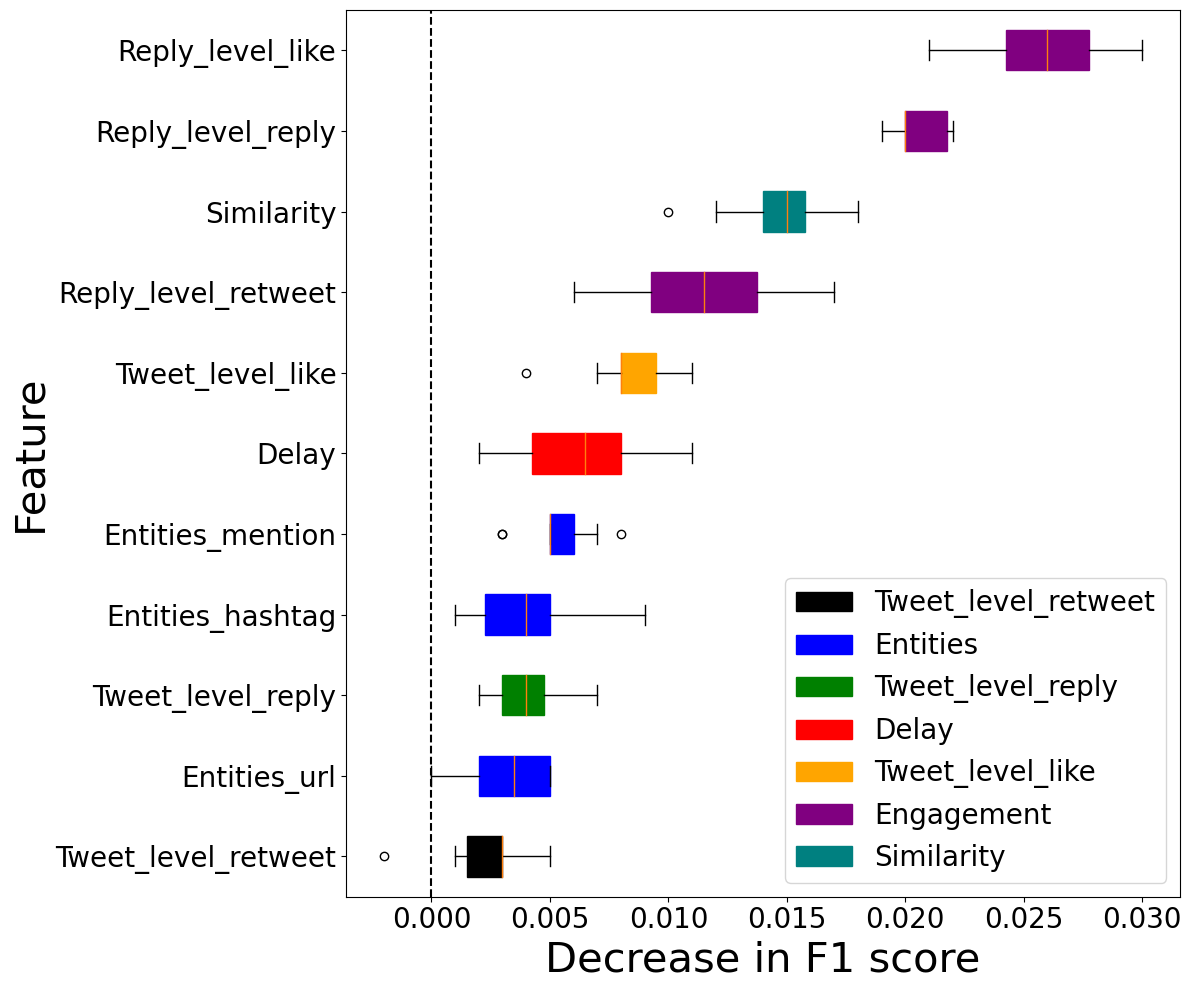

In [45]:
fig, ax = plt.subplots(figsize=(12, 10))

ax, labels = plot_feature_importance(all_data,
                           ax
                           )

ax.set_xlabel("Decrease in F1 score", fontsize=30)
ax.set_ylabel("Feature", fontsize=30)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

ax.figure.tight_layout()

filename = f'./../plots/tweet_classifier_feature_importance.png'

fig.savefig(filename, 
      facecolor='white', 
      transparent=False
           )
plt.show()